Esse Notebook será dedicado a experimentar como os modelos classicos aprendem com os dados youtube e spotify.

* Primeiro será feito um teste com os modelos sem nenhum ajuste previo para entender como tão prevendo os dados em primeiro momento.

* Em segundo momento será testado como a idade dos dados ta afetenado previsão do modelo em 3 diferentes faixas de tempo.

* Retirar os outliers e ver como o modelo padrão de menor erro se comporta

possiveis melhorias:
*   tirar os outliers de engajamento
*   utilizar tecnicas como SMOTE para aumentar o numero de musicas com ate 30 dias
*   tirar outliers

Descobertas:
* Utilizar apenas musicas recentes não garante que vamos ter resultados melhores, portanto pode usar todas as musicas
* Musicas com mais dias são mais faceis de prever
* Retirar os outliers não trouxe grande melhoria
* Conforme vai ficando maior a idade dos videos mais preciso fica a regressão
* Se retirar os outliers do conjunto de treinamento o numero de streams ajuda na predição

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.linear_model import  LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

In [ ]:
# ruff: noqa: E402
import math
import warnings
from typing import Dict, Literal

warnings.simplefilter("ignore")
import delu  # Deep Learning Utilities: https://github.com/Yura52/delu
import numpy as np
import scipy.special
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch
import torch.nn.functional as F
import torch.optim
from torch import Tensor
from tqdm.std import tqdm

warnings.resetwarnings()

from rtdl_revisiting_models import MLP, ResNet, FTTransformer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set random seeds in all libraries.
delu.random.seed(0)

# Tratamento dos dados

In [269]:
spotify_youtube_pt1 = pd.read_csv("Dados/spotify_youtube_up_pt1.csv")
spotify_youtube_pt2 = pd.read_csv("Dados/spotify_youtube_up_pt2.csv")

In [270]:
data_extracao = pd.to_datetime("2023-02-07")
spotify_youtube_pt1["upload_date"] = pd.to_datetime(spotify_youtube_pt1["upload_date"])
spotify_youtube_pt1["dias_na_plataforma"] = (data_extracao - spotify_youtube_pt1["upload_date"]).dt.days

spotify_youtube_pt2["upload_date"] = pd.to_datetime(spotify_youtube_pt2["upload_date"])
spotify_youtube_pt2["dias_na_plataforma"] = (data_extracao - spotify_youtube_pt2["upload_date"]).dt.days

In [271]:
spotify_youtube = pd.concat([spotify_youtube_pt1,spotify_youtube_pt2])

In [272]:
spotify_youtube_dummies= pd.get_dummies(spotify_youtube,columns=['Album_type'], dtype=int)

In [273]:
spotify_youtube_dummies['artist_number'] = spotify_youtube_dummies['Artist'].str.split(',').str.len()
spotify_youtube_dummies['engagement_rate'] = spotify_youtube_dummies.apply(lambda row: (row['Likes'] + row['Comments']) / row['Views'] * 100 if row['Views'] > 0 else 0, axis=1)

In [274]:
columns_drop=['Unnamed: 0', 'Artist', 'Url_spotify', 'Track', 'Album', 'Uri','Url_youtube', 'Title', 'Channel', 'Views', 'Likes','Comments', 'Description', 'Licensed', 'official_video', 'upload_date','Stream']
spotify_youtube_df=spotify_youtube_dummies.drop(columns=columns_drop)

In [275]:
spotify_youtube_limpo=spotify_youtube_df.dropna(subset=['Danceability','Energy','Key','Loudness','Speechiness','Acousticness', 'Instrumentalness','Liveness','Valence','Tempo','Duration_ms','engagement_rate'])

# Preparação dos dados para os experimentos

In [328]:
youtube_30_df=spotify_youtube_limpo[spotify_youtube_limpo['dias_na_plataforma']<31]
youtube_90_df=spotify_youtube_limpo[spotify_youtube_limpo['dias_na_plataforma']<91]
youtube_365_df=spotify_youtube_limpo[spotify_youtube_limpo['dias_na_plataforma']<366]

In [329]:
spotify_youtube_df_366_more = spotify_youtube_limpo.drop(youtube_365_df.index)
spotify_youtube_df_91_365 = youtube_365_df.drop(youtube_90_df.index)
spotify_youtube_df_31_90 = youtube_365_df.drop(youtube_30_df.index)

Total number of outliers in column engagement_rate: 592
Lower limit: -0.4855731167119207, Upper limit: 2.251193229196198
-----------------------------------------------------------


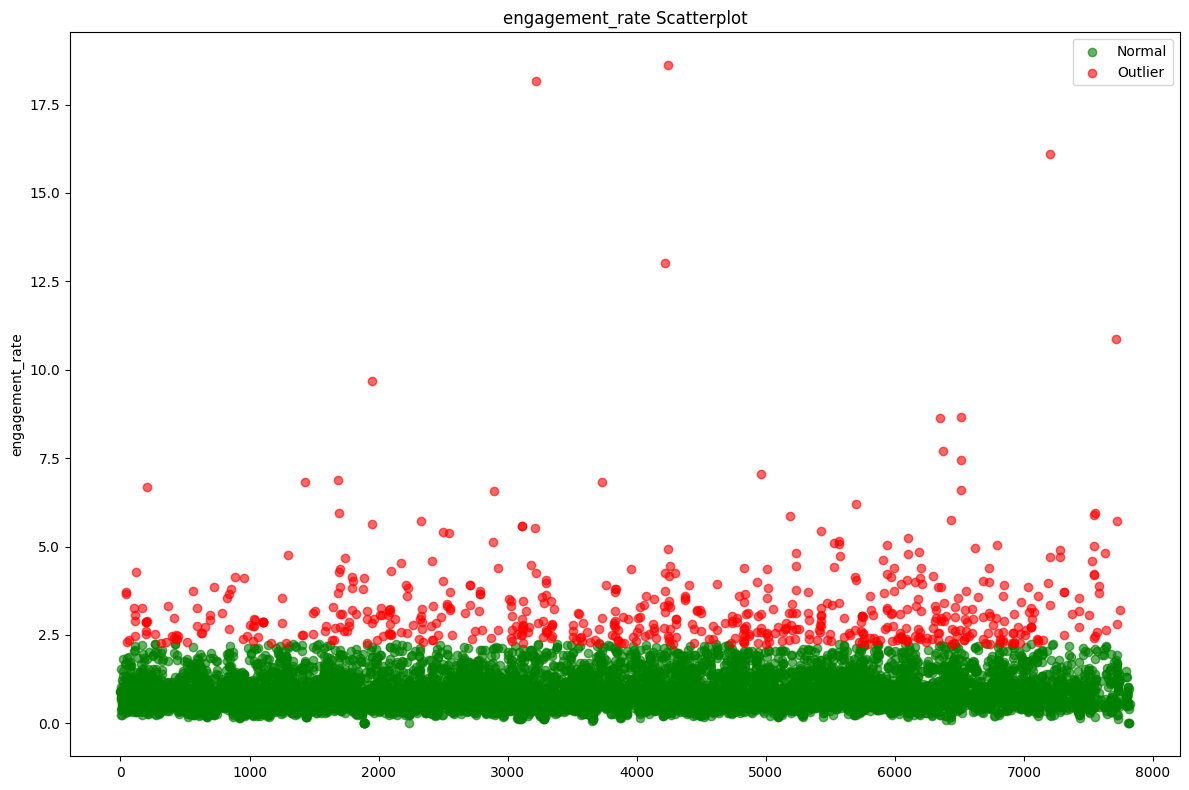

In [330]:
def find_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound


columns_to_check = ["engagement_rate"]


plt.figure(figsize = (12, 8))
for i, col in enumerate(columns_to_check, 1):

    outliers, lower, upper = find_outliers_iqr(spotify_youtube_df_366_more, col)

   
    normal_values = spotify_youtube_df_366_more[(spotify_youtube_df_366_more[col] >= lower) & (spotify_youtube_df_366_more[col] <= upper)]

    
    plt.subplot(1, 1, i)
    plt.scatter(normal_values.index, normal_values[col], label = "Normal", alpha = 0.6, c = "green")
    plt.scatter(outliers.index, outliers[col], label = "Outlier", alpha=0.6, c = "red")
    plt.title(f"{col} Scatterplot")
    plt.ylabel(col)
    plt.legend()

    
    print(f"Total number of outliers in column {col}: {len(outliers)}")
    print(f"Lower limit: {lower}, Upper limit: {upper}")
    print("-" * 59)

plt.tight_layout()
plt.show()

In [331]:
youtube_30_df=youtube_30_df[youtube_30_df['engagement_rate']<9.338507725109846]
spotify_youtube_df_31_90=spotify_youtube_df_31_90[spotify_youtube_df_31_90['engagement_rate']<4.602401258613792]
spotify_youtube_df_91_365=spotify_youtube_df_91_365[spotify_youtube_df_91_365['engagement_rate']<4.253191569584401]
spotify_youtube_df_366_more=spotify_youtube_df_366_more[spotify_youtube_df_366_more['engagement_rate']<2.251193229196198]

In [332]:
youtube_30_df_x = youtube_30_df.drop('engagement_rate',axis=1)
youtube_30_df_y = youtube_30_df['engagement_rate']

spotify_youtube_df_31_90_x = spotify_youtube_df_31_90.drop('engagement_rate',axis=1)
spotify_youtube_df_31_90_y = spotify_youtube_df_31_90['engagement_rate']

spotify_youtube_df_91_365_x = spotify_youtube_df_91_365.drop('engagement_rate',axis=1)
spotify_youtube_df_91_365_y = spotify_youtube_df_91_365['engagement_rate']

spotify_youtube_df_366_more_x = spotify_youtube_df_366_more.drop('engagement_rate',axis=1)
spotify_youtube_df_366_more_y = spotify_youtube_df_366_more['engagement_rate']

In [333]:
spotify_youtube_30X_train, spotify_youtube_30X_test, spotify_youtube_30y_train, spotify_youtube_30y_test = train_test_split(youtube_30_df_x, youtube_30_df_y, test_size=0.25, random_state=42)
spotify_youtube_df_31_90X_train, spotify_youtube_df_31_90X_test, spotify_youtube_df_31_90y_train, spotify_youtube_df_31_90y_test = train_test_split(spotify_youtube_df_31_90_x, spotify_youtube_df_31_90_y, test_size=0.25, random_state=42)
spotify_youtube_df_91_365X_train, spotify_youtube_df_91_365X_test, spotify_youtube_df_91_365y_train, spotify_youtube_df_91_365y_test = train_test_split(spotify_youtube_df_91_365_x, spotify_youtube_df_91_365_y, test_size=0.25, random_state=42)

In [334]:
# Dados de treino 
sy_x_train=pd.concat([spotify_youtube_30X_train,spotify_youtube_df_31_90X_train,spotify_youtube_df_91_365X_train,spotify_youtube_df_366_more_x])
sy_y_train=pd.concat([spotify_youtube_30y_train,spotify_youtube_df_31_90y_train,spotify_youtube_df_91_365y_train,spotify_youtube_df_366_more_y])

In [335]:
sy_90_x_train=pd.concat([spotify_youtube_30X_train,spotify_youtube_df_31_90X_train])
sy_90_y_train=pd.concat([spotify_youtube_30y_train,spotify_youtube_df_31_90y_train])

In [336]:
sy_365_x_train=pd.concat([spotify_youtube_30X_train,spotify_youtube_df_31_90X_train,spotify_youtube_df_91_365X_train])
sy_365_y_train=pd.concat([spotify_youtube_30y_train,spotify_youtube_df_31_90y_train,spotify_youtube_df_91_365y_train])

In [337]:
# Para testar o desempenho do modelo com videos com ate 30 dias
sy_30_x_test=spotify_youtube_30X_test
sy_30_y_test=spotify_youtube_30y_test

# Para testar o desempenho do modelo com videos com ate 90 dias
sy_90_x_test=pd.concat([spotify_youtube_30X_test,spotify_youtube_df_31_90X_test])
sy_90_y_test=pd.concat([spotify_youtube_30y_test,spotify_youtube_df_31_90y_test])

# Para testar o desempenho do modelo com videos com ate 1 ano
sy_365_x_test=pd.concat([spotify_youtube_30X_test,spotify_youtube_df_31_90X_test,spotify_youtube_df_91_365X_test])
sy_365_y_test=pd.concat([spotify_youtube_30y_test,spotify_youtube_df_31_90y_test,spotify_youtube_df_91_365y_test])

# Transformers

In [ ]:
TaskType = Literal["regression", "binclass", "multiclass"]

task_type: TaskType = "regression"
n_classes = None
dataset = sklearn.datasets.fetch_california_housing()
X_cont: np.ndarray = youtube_30_df_x.values
Y: np.ndarray = youtube_30_df_y.values

# NOTE: uncomment to solve a classification task.
# n_classes = 2
# assert n_classes >= 2
# task_type: TaskType = 'binclass' if n_classes == 2 else 'multiclass'
# X_cont, Y = sklearn.datasets.make_classification(
#     n_samples=20000,
#     n_features=8,
#     n_classes=n_classes,
#     n_informative=3,
#     n_redundant=2,
# )

# >>> Continuous features.
X_cont: np.ndarray = X_cont.astype(np.float32)
n_cont_features = X_cont.shape[1]

# >>> Categorical features.
# NOTE: the above datasets do not have categorical features, but,
# for the demonstration purposes, it is possible to generate them.
cat_cardinalities = [
    # NOTE: uncomment the two lines below to add two categorical features.
    # 4,  # Allowed values: [0, 1, 2, 3].
    # 7,  # Allowed values: [0, 1, 2, 3, 4, 5, 6].
]
X_cat = (
    np.column_stack(
        [np.random.randint(0, c, (len(X_cont),)) for c in cat_cardinalities]
    )
    if cat_cardinalities
    else None
)

# >>> Labels.
# Regression labels must be represented by float32.
if task_type == "regression":
    Y = Y.astype(np.float32)
else:
    assert n_classes is not None
    Y = Y.astype(np.int64)
    assert set(Y.tolist()) == set(
        range(n_classes)
    ), "Classification labels must form the range [0, 1, ..., n_classes - 1]"

# >>> Split the dataset.
all_idx = np.arange(len(Y))
trainval_idx, test_idx = sklearn.model_selection.train_test_split(
    all_idx, train_size=0.8
)
train_idx, val_idx = sklearn.model_selection.train_test_split(
    trainval_idx, train_size=0.8
)
data_numpy = {
    "train": {"x_cont": X_cont[train_idx], "y": Y[train_idx]},
    "val": {"x_cont": X_cont[val_idx], "y": Y[val_idx]},
    "test": {"x_cont": X_cont[test_idx], "y": Y[test_idx]},
}
if X_cat is not None:
    data_numpy["train"]["x_cat"] = X_cat[train_idx]
    data_numpy["val"]["x_cat"] = X_cat[val_idx]
    data_numpy["test"]["x_cat"] = X_cat[test_idx]

In [ ]:
# >>> Feature preprocessing.
# NOTE
# The choice between preprocessing strategies depends on a task and a model.

# (A) Simple preprocessing strategy.
# preprocessing = sklearn.preprocessing.StandardScaler().fit(
#     data_numpy['train']['x_cont']
# )

# (B) Fancy preprocessing strategy.
# The noise is added to improve the output of QuantileTransformer in some cases.
X_cont_train_numpy = data_numpy["train"]["x_cont"]
noise = (
    np.random.default_rng(0)
    .normal(0.0, 1e-5, X_cont_train_numpy.shape)
    .astype(X_cont_train_numpy.dtype)
)
preprocessing = sklearn.preprocessing.QuantileTransformer(
    n_quantiles=max(min(len(train_idx) // 30, 1000), 10),
    output_distribution="normal",
    subsample=10**9,
).fit(X_cont_train_numpy + noise)
del X_cont_train_numpy

for part in data_numpy:
    data_numpy[part]["x_cont"] = preprocessing.transform(data_numpy[part]["x_cont"])

# >>> Label preprocessing.
if task_type == "regression":
    Y_mean = data_numpy["train"]["y"].mean().item()
    Y_std = data_numpy["train"]["y"].std().item()
    for part in data_numpy:
        data_numpy[part]["y"] = (data_numpy[part]["y"] - Y_mean) / Y_std

# >>> Convert data to tensors.
data = {
    part: {k: torch.as_tensor(v, device=device) for k, v in data_numpy[part].items()}
    for part in data_numpy
}

if task_type != "multiclass":
    # Required by F.binary_cross_entropy_with_logits
    for part in data:
        data[part]["y"] = data[part]["y"].float()

In [ ]:
# The output size.
d_out = n_classes if task_type == "multiclass" else 1

model = FTTransformer(
    n_cont_features=n_cont_features,
    cat_cardinalities=cat_cardinalities,
    d_out=d_out,
    **FTTransformer.get_default_kwargs(),
).to(device)
optimizer = model.make_default_optimizer()

In [ ]:
def apply_model(batch: Dict[str, Tensor]) -> Tensor:
    if isinstance(model, (MLP, ResNet)):
        x_cat_ohe = (
            [
                F.one_hot(column, cardinality)
                for column, cardinality in zip(batch["x_cat"].T, cat_cardinalities)
            ]
            if "x_cat" in batch
            else []
        )
        return model(torch.column_stack([batch["x_cont"]] + x_cat_ohe)).squeeze(-1)

    elif isinstance(model, FTTransformer):
        return model(batch["x_cont"], batch.get("x_cat")).squeeze(-1)

    else:
        raise RuntimeError(f"Unknown model type: {type(model)}")


loss_fn = (
    F.binary_cross_entropy_with_logits
    if task_type == "binclass"
    else F.cross_entropy
    if task_type == "multiclass"
    else F.mse_loss
)


@torch.no_grad()
def evaluate(part: str) -> float:
    model.eval()

    eval_batch_size = 8096
    y_pred = (
        torch.cat(
            [
                apply_model(batch)
                for batch in delu.iter_batches(data[part], eval_batch_size)
            ]
        )
        .cpu()
        .numpy()
    )
    y_true = data[part]["y"].cpu().numpy()

    if task_type == "binclass":
        y_pred = np.round(scipy.special.expit(y_pred))
        score = sklearn.metrics.accuracy_score(y_true, y_pred)
    elif task_type == "multiclass":
        y_pred = y_pred.argmax(1)
        score = sklearn.metrics.accuracy_score(y_true, y_pred)
    else:
        assert task_type == "regression"
        #score = -(sklearn.metrics.mean_squared_error(y_true, y_pred) ** 0.5 * Y_std)
        score = sklearn.metrics.mean_squared_error(y_true, y_pred)
    return score  # The higher -- the better.


print(f'Test score before training: {evaluate("test"):.4f}')

Test score before training: 1.1058


In [ ]:
# For demonstration purposes (fast training and bad performance),
# one can set smaller values:
# n_epochs = 20
# patience = 2

n_epochs = 1_000_000_000 
patience = 16

batch_size = 256
epoch_size = math.ceil(len(train_idx) / batch_size)
timer = delu.tools.Timer()

# MSE: queremos minimizar -> mode="min"
early_stopping = delu.tools.EarlyStopping(patience, mode="min")

best = {
    "val": float("inf"),
    "test": float("inf"),
    "epoch": -1,
}

print(f"Device: {device.type.upper()}")
print("-" * 88 + "\n")
timer.run()

for epoch in range(n_epochs):
    for batch in tqdm(
        delu.iter_batches(data["train"], batch_size, shuffle=True),
        desc=f"Epoch {epoch}",
        total=epoch_size,
    ):
        model.train()
        optimizer.zero_grad()
        loss = loss_fn(apply_model(batch), batch["y"])
        loss.backward()
        optimizer.step()

    val_score = evaluate("val")
    test_score = evaluate("test")
    print(f"(val) {val_score:.4f} (test) {test_score:.4f} [time] {timer}")

    early_stopping.update(val_score)
    if early_stopping.should_stop():
        break

    if test_score < best["test"]:
        print("🌸 New best epoch! 🌸")
        best = {"val": val_score, "test": test_score, "epoch": epoch}
    print()

print("\n\nResult:")
print(best)

Device: CPU
----------------------------------------------------------------------------------------



Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


(val) 1.1534 (test) 0.9827 [time] 0:00:00.281077
🌸 New best epoch! 🌸



Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


(val) 1.0914 (test) 0.9746 [time] 0:00:00.522429
🌸 New best epoch! 🌸



Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


(val) 1.0725 (test) 0.9167 [time] 0:00:00.747462
🌸 New best epoch! 🌸



Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


(val) 1.0813 (test) 0.9177 [time] 0:00:00.969480



Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


(val) 1.0722 (test) 0.9199 [time] 0:00:01.236411



Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


(val) 1.0755 (test) 0.9297 [time] 0:00:01.488259



Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


(val) 1.0669 (test) 0.9273 [time] 0:00:01.784419



Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


(val) 1.0532 (test) 0.9274 [time] 0:00:02.005136



Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


(val) 1.0369 (test) 0.9255 [time] 0:00:02.304747



Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


(val) 1.0195 (test) 0.9222 [time] 0:00:02.579630



Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


(val) 1.0031 (test) 0.9225 [time] 0:00:02.804850



Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


(val) 0.9927 (test) 0.9252 [time] 0:00:03.080825



Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


(val) 0.9879 (test) 0.9253 [time] 0:00:03.368050



Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


(val) 0.9727 (test) 0.9149 [time] 0:00:03.633004
🌸 New best epoch! 🌸



Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


(val) 0.9672 (test) 0.9147 [time] 0:00:03.899559
🌸 New best epoch! 🌸



Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


(val) 0.9689 (test) 0.9126 [time] 0:00:04.148345
🌸 New best epoch! 🌸



Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


(val) 0.9815 (test) 0.9178 [time] 0:00:04.427411



Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


(val) 0.9894 (test) 0.9211 [time] 0:00:04.693121



Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


(val) 0.9814 (test) 0.9114 [time] 0:00:04.947067
🌸 New best epoch! 🌸



Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


(val) 0.9689 (test) 0.9061 [time] 0:00:05.333397
🌸 New best epoch! 🌸



Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


(val) 0.9666 (test) 0.9066 [time] 0:00:05.540326



Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


(val) 0.9768 (test) 0.9047 [time] 0:00:05.813938
🌸 New best epoch! 🌸



Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


(val) 0.9887 (test) 0.9063 [time] 0:00:06.053537



Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


(val) 0.9678 (test) 0.8892 [time] 0:00:06.306308
🌸 New best epoch! 🌸



Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


(val) 0.9549 (test) 0.8816 [time] 0:00:06.558850
🌸 New best epoch! 🌸



Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


(val) 0.9558 (test) 0.8714 [time] 0:00:06.823581
🌸 New best epoch! 🌸



Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


(val) 0.9853 (test) 0.8763 [time] 0:00:07.075283



Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


(val) 0.9982 (test) 0.8817 [time] 0:00:07.323522



Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


(val) 0.9528 (test) 0.8546 [time] 0:00:07.577938
🌸 New best epoch! 🌸



Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


(val) 0.9440 (test) 0.8592 [time] 0:00:07.838242



Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


(val) 0.9710 (test) 0.8563 [time] 0:00:08.090439



Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


(val) 1.0347 (test) 0.8888 [time] 0:00:08.353802



Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


(val) 1.0176 (test) 0.8776 [time] 0:00:08.680212



Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


(val) 0.9942 (test) 0.8746 [time] 0:00:08.927482



Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


(val) 1.0016 (test) 0.8818 [time] 0:00:09.184067



Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


(val) 1.0329 (test) 0.9042 [time] 0:00:09.429341



Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


(val) 1.0511 (test) 0.9255 [time] 0:00:09.660105



Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


(val) 1.0397 (test) 0.9214 [time] 0:00:09.895584



Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


(val) 1.0383 (test) 0.9236 [time] 0:00:10.131081



Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


(val) 1.0494 (test) 0.9307 [time] 0:00:10.378302



Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


(val) 1.0608 (test) 0.9311 [time] 0:00:10.662094



Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


(val) 1.0807 (test) 0.9443 [time] 0:00:10.991688



Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


(val) 1.1139 (test) 0.9675 [time] 0:00:11.250423



Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


(val) 1.0985 (test) 0.9529 [time] 0:00:11.495438



Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


(val) 1.0875 (test) 0.9506 [time] 0:00:11.765383



Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

(val) 1.0908 (test) 0.9621 [time] 0:00:12.013120


Result:
{'val': 0.9527732729911804, 'test': 0.8546126484870911, 'epoch': 28}
